## Семинар 10: "Генерация текстов"

ФИО:

In [47]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [48]:
!head -n 2 author-quote.txt

A. A. Milne	If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.
A. A. Milne	Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.


In [49]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]

In [50]:
m = map(len, lines)

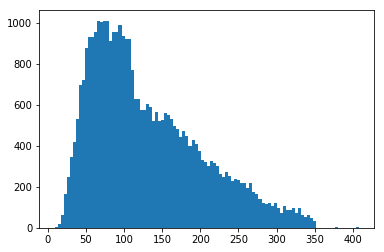

In [51]:
plt.hist(list(map(len, lines)), bins=100);

In [52]:
line = lines[0]

In [53]:
line

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

In [54]:
lines = list(filter(lambda x: len(x) <= 50, lines))

In [55]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(all_characters)+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return np.array([self.char_to_id[x] for x in line])
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [56]:
vocab = Vocabulary(lines)

In [57]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [58]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        input = self.vocab.encode(['<go>'] + list(self.sentences[idx]))
        output = self.vocab.encode(list(self.sentences[idx])+['<eos>'])
        return input, output

In [59]:
dataset = Quotes(lines, vocab)

In [60]:
dataloader = DataLoader(dataset, shuffle=True)

### Часть 2: определение модели

In [71]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=True)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)
    
    def forward(self, input):
        embedding = self.embedding(input)
        h = Variable(torch.Tensor(self.layers, 1, self.hidden_size).normal_().cuda(), requires_grad=False)*0
        output, _ = self.generator(embedding, (h))
        classes = self.classifier(output[0])
        return classes
    
    def generate(self, vocab, max_len=100, T=1.0):
        h = Variable(torch.Tensor(self.layers, 1, self.hidden_size).normal_().cuda(), requires_grad=False)*0
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long().cuda()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
#             new_token_id = np.argmax(classes.data.cpu().numpy())
            probs = classes.data.cpu().numpy().reshape(-1)
            probs = np.exp(probs / T - np.max(probs / T)) / np.sum(np.exp(probs / T - np.max(probs / T)))
            new_token_id = np.random.choice(probs.shape[0], size=1, p=probs)[0]
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [72]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2).cuda()

### Часть 3: обучение модели

In [73]:
optimizer = torch.optim.Adam(oracle.parameters(), lr=0.01)

In [74]:
criterion = nn.CrossEntropyLoss()

In [75]:
losses = []

In [76]:
for epoch in range(1000):
    for i, (batch, target) in enumerate(dataloader):
        batch = Variable(batch).cuda()
        target = Variable(target, requires_grad=False)[0].cuda()
        prediction = oracle(batch)
        loss = criterion(prediction, target)
        loss.backward()
        if i % 512 == 0: # aka batch
            optimizer.step()
            oracle.zero_grad()
            losses.append(loss.data[0])
            print('{} / {}:'.format(epoch, 1000), loss.data[0], oracle.generate(vocab, T=0.1))

0 / 1000: 4.2887396812438965 lFaioenh xttyaeeeaate.rtaueft?aeexr..tr<go>-tfBxeee..tvvr-uee.'ertuaaerr$8CDfeB.aK6Wt6I-.kieaYeeefut
0 / 1000: 4.15047550201416 .r6Beyueee.u.e....'mn-e  aa s e aeaeead eaaeae es aaeee.e. enyeese  aeaae eeaea emdeaaue .ea eueaes 
0 / 1000: 3.757392406463623 e aeaaa eaea   aaaaeeaea eaa aaee ea a anaaaae   aaaaeeae ea aae aaaea a  aeaea  aae aaaae e a aaeaa
0 / 1000: 3.3503518104553223 d     e        e   e      e      e  e                          e        e    e e      e      e   n  
0 / 1000: 3.155200719833374 o                                                                                                   
0 / 1000: 3.073493242263794                                                                                                     
0 / 1000: 3.3842451572418213                  e    t           e              e                       e                e         
0 / 1000: 3.307743549346924  e    e e e  e              e  e  e      e  e     e  e e    e      

2 / 1000: 2.273136854171753 I mean a to to to to to to the are are are.<eos>
2 / 1000: 2.08303165435791 I man a to to the to in to in to to the the on in to to on.<eos>
2 / 1000: 2.3417248725891113 I meat a to to to the the to to to to to the to to to the to the to the to to to to to to the to the
2 / 1000: 2.2350893020629883 I mean a to to to to to the the to the the to the to the to the the to the to to to the to the.<eos>
2 / 1000: 2.3612091541290283 I man a the to to the to to the to to the the the to the to the.<eos>
2 / 1000: 1.9488457441329956 I won the to to the to the the the the are in the the to the to the the to the.<eos>
2 / 1000: 2.0677175521850586 I man a to the to the to the to the to the the to the to the the the the the to the the the the.<eos>
2 / 1000: 2.1589102745056152 I mere a to the to the to to the to the the to the the on.<eos>
2 / 1000: 2.068168878555298 I don a the to the a to the a to the are are are.<eos>
2 / 1000: 1.9708341360092163 I don to the to the th

4 / 1000: 1.8813560009002686 I love a so the the wored is the so the some.<eos>
4 / 1000: 1.578196406364441 I love a so the be the bealling the the man.<eos>
4 / 1000: 1.9842604398727417 I love and a some and a some.<eos>
4 / 1000: 1.9304285049438477 I love a some and a some the the the some.<eos>
4 / 1000: 1.9734790325164795 I love the strang the the the be is the the the sour.<eos>
5 / 1000: 1.9939031600952148 I love a some a sound is a sour and a sour man.<eos>
5 / 1000: 1.6725691556930542 I love a the the the the the a the the the the be.<eos>
5 / 1000: 1.5664786100387573 I love a the the the be the be a the be is a wor.<eos>
5 / 1000: 1.836038589477539 I love a the the the the be is the the the the the be.<eos>
5 / 1000: 1.2049875259399414 I love a the the be of a the the the the the more is the the the more.<eos>
5 / 1000: 2.2746195793151855 I love a the the the the the be the the the the be.<eos>
5 / 1000: 2.4214837551116943 I love a the the the the the the be is the the the the

8 / 1000: 1.4446470737457275 I don't good to be and stality.<eos>
8 / 1000: 1.8691178560256958 I don't great to be a cand in the the some.<eos>
8 / 1000: 1.8433483839035034 I don't go the can the comes in my some.<eos>
8 / 1000: 1.867987036705017 I love a chant the persess.<eos>
8 / 1000: 1.559664011001587 I love the persed a chally a chally and a chart.<eos>
8 / 1000: 1.9940154552459717 I love a part the persess.<eos>
8 / 1000: 1.7058571577072144 I love a start is a strong and a stray.<eos>
8 / 1000: 2.3788723945617676 I love to a straes a prest.<eos>
8 / 1000: 1.8753117322921753 I love to be a strong to be a strong.<eos>
8 / 1000: 1.6504613161087036 I love to be a booker to be a strolition.<eos>
8 / 1000: 1.577694296836853 I love to be a sear to be a beally to be to be a book.<eos>
8 / 1000: 1.9319360256195068 I love a salite in the be are a strong.<eos>
8 / 1000: 1.9535231590270996 I love the be of a comes a comes.<eos>
8 / 1000: 1.8964513540267944 I love the be in a can the best a 

12 / 1000: 1.7311291694641113 I love to do to do the best the more the more.<eos>
12 / 1000: 1.517758846282959 I love to be a coung to who stay.<eos>
12 / 1000: 2.0319712162017822 I love to be a conestion in a coung.<eos>
12 / 1000: 1.2171744108200073 I love a can the pressent.<eos>
12 / 1000: 1.7431262731552124 I like the pear the pressent.<eos>
12 / 1000: 1.2554253339767456 I love to be a beat a compally.<eos>
12 / 1000: 1.7810335159301758 I don't like the people to be a beauty.<eos>
12 / 1000: 1.980692982673645 I don't do the beauty to be a beauty.<eos>
12 / 1000: 1.7945061922073364 I don't like to be a start.<eos>
12 / 1000: 1.6382277011871338 I don't a good a soul the polity.<eos>
12 / 1000: 1.4255261421203613 I am a start of the soul to be a star.<eos>
12 / 1000: 1.6910122632980347 I am a soul the work to be a start.<eos>
12 / 1000: 1.469460129737854 I love to be a sex of the soul.<eos>
12 / 1000: 1.2532283067703247 I don't be all to be a self.<eos>
12 / 1000: 1.6160277128219604 

KeyboardInterrupt: 

In [95]:
oracle.generate(vocab, T=0.5)

'All the can is the sing for before.<eos>'

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

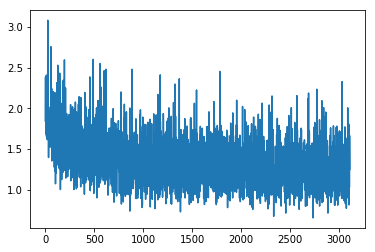

In [90]:
plt.plot(losses)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: